## Repeated validations


import metrics here

In [30]:
from sklearn.metrics import f1_score, accuracy_score,roc_auc_score

import models here

In [31]:

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier


In [32]:
import numpy as np
import biutils
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.ticker as mtick


In [33]:
def randcat4():
    rs = np.random.randint(43219)
    return CatBoostClassifier(**{'n_estimators':60},random_state=rs,verbose=0)
cat4 =  randcat4()
def randsvc(C):
    rs = np.random.RandomState()
    svcm = SVC(C=C, kernel='linear',probability = True,random_state = rs)
    return svcm

    
ada4 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_features=0.8),
                   learning_rate=1.5, n_estimators=260, random_state=np.random.RandomState())
svm4 = randsvc(0.5)

cat4 =  randcat4()
rf4 = RandomForestClassifier(max_depth=3, min_samples_leaf=4, n_estimators=175,
                       random_state=np.random.RandomState())
glf4 = GradientBoostingClassifier(max_depth=2, min_samples_leaf=0.1,
                           min_samples_split=0.1, random_state=4,n_estimators=100)
xgb4 = xgb.XGBClassifier( booster='gbtree',  learning_rate=0.1, max_depth=2, max_leaves=None,
              min_child_weight=3,  n_estimators=200, predictor=None, random_state=np.random.RandomState())
dt4 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                        max_features=0.6,
                                                        random_state=np.random.RandomState()),
                  bootstrap_features=True, max_samples=0.8, n_estimators=30,
                  random_state=np.random.RandomState())
tree4 = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=np.random.RandomState())

specify model names

In [35]:
mdls = [tree4,svm4,dt4,rf4,ada4,glf4,xgb4,cat4]
names = ["Decision Tree","Linear SVM","DT-based Bagging","RandomForest","AdaBoost","GradientBoost","XGBoost","CatBoost"]

specify data

In [34]:
# retrieve table from database
binary = biutils.get_tbl('binary')
no_out = biutils.get_tbl('bino_out')
zdata = biutils.get_tbl("bizdata")

specify variables

In [36]:

intervars =['triglycerylfatcrossp(TGFRupper) FAT14ratio', 
'methylfat(FMETD10) FAT14ratio', 
'olefinicfat(UFD54) FAT14ratio', 
'fat(4p2_3p9) FAT14ratio', 
'methylenefat(FAT21) FAT14ratio', 
'fat(2p06_1p32) ratioWAT47_1d', 
'adc', 'gly+myo FAT14ratio', 
'fat(1p32_0p9) FAT14ratio']

intername = ['TGFRupper/FAT14','FMETD/FAT14','UFD54/FAT14','CP8/FAT14',
'FAT21/FAT14','CP4/FAT14','ADC','mI+Gly/FAT14','CP2/FAT14']

renamed = no_out[intervars+['voxel','dataset','label']]
renamed = renamed.rename(columns=dict(zip(intervars,intername)))

re_dict = dict(zip(intervars,intername))
re_dict

{'triglycerylfatcrossp(TGFRupper) FAT14ratio': 'TGFRupper/FAT14',
 'methylfat(FMETD10) FAT14ratio': 'FMETD/FAT14',
 'olefinicfat(UFD54) FAT14ratio': 'UFD54/FAT14',
 'fat(4p2_3p9) FAT14ratio': 'CP8/FAT14',
 'methylenefat(FAT21) FAT14ratio': 'FAT21/FAT14',
 'fat(2p06_1p32) ratioWAT47_1d': 'CP4/FAT14',
 'adc': 'ADC',
 'gly+myo FAT14ratio': 'mI+Gly/FAT14',
 'fat(1p32_0p9) FAT14ratio': 'CP2/FAT14'}

reorder the models as how they would appear in the graph from left to right (1, 2, 3, ...)

In [38]:
mod_dict = dict(zip(['Decision Tree','Linear SVM', 'DT-based Bagging', 'RandomForest', 'AdaBoost',
       'GradientBoost', 'XGBoost', 'CatBoost'],[1,2,3,5,7,8,6,4]))

### Model comparisons

Specification: https://scikit-learn.org/stable/tutorial/basic/tutorial.html Refitting and updating parameters parts. Calling fit more than once would overwrite previous memory of the same model


In [40]:
X = no_out[intervars]
print(X.shape)
y =  LabelEncoder().fit_transform(no_out.label)

(436, 9)


calculate cv scores

In [41]:


# Empty lists to store scores
f1 = []
auc = []
acc = []
precision = []
recall = []
specificity = []
sensitivity = []
mdl_names = []

def confusion_matrix_scorer(clf, X, y):
       y_pred = clf.predict(X)
       cm = confusion_matrix(y, y_pred)
       return {'tn': cm[0, 0], 'fp': cm[0, 1],
              'fn': cm[1, 0], 'tp': cm[1, 1]}

for i in range(20):
    for k in range(len(names)):
        mdl = mdls[k]
        if names[k] != 'CatBoost':
            mdl.set_params(**{'random_state': np.random.randint(1000)})
        cvresult = cross_validate(mdl, X, y, groups=list(no_out.dataset), scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'], cv=StratifiedGroupKFold(5), verbose=0)
        cm = cross_validate(mdl, X, y, groups=list(no_out.dataset), scoring=confusion_matrix_scorer, cv=StratifiedGroupKFold(5), verbose=0)
       
        tn = cm['test_tn']
        fp = cm['test_fp']
        fn = cm['test_fn']
        tp = cm['test_tp']
        
    
        f1 += list(cvresult['test_f1'])
        acc += list(cvresult['test_accuracy'])
        auc += list(cvresult['test_roc_auc'])
        precision += list(cvresult['test_precision'])
        recall += list(cvresult['test_recall'])
        mdl_names += [names[k] for i in range(5)]
        sensitivity += list(tp / (tp + fn))
        specificity += list(tn / (tn + fp))

# Create DataFrame
cvdf = pd.DataFrame({'F1_score': f1, 'Accuracy': acc, 'AUC': auc, 'Precision': precision, 'Recall': recall, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Model': mdl_names})
melted = cvdf.melt(id_vars=['Model'], var_name='Metric', value_name='Score')



/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

In [16]:
#save to file
melted.to_csv('fv_cv.csv')

define colors

In [42]:
#boxplot
colors = [
    (1.0, 0.85, 0.85),   # Very Light Red
    (1.0, 0.9, 0.8),     # Very Light Orange
    (1.0, 1.0, 0.85),    # Very Light Yellow
    (0.85, 1.0, 0.85),   # Very Light Green
    (0.85, 0.85, 1.0),   # Very Light Blue
    (0.9, 0.85, 1.0),    # Very Light Indigo
    (1.0, 0.85, 1.0),    # Very Light Violet
    (1.0,0.9,0.9)
]
#swarmplot
colors2= [
    (1.0, 0.5, 0.5),   # Light Red
    (1.0, 0.75, 0.5),  # Light Orange
    (1.0, 1.0, 0.5),   # Light Yellow
    (0.5, 1.0, 0.5),   # Light Green
    (0.5, 0.5, 1.0),   # Light Blue
    (0.75, 0.5, 1.0),  # Light Indigo
    (1.0, 0.5, 1.0),    # Light Violet
     (1.0, 0.8, 0.8)  # Light Pink
]


plots for cv

read file

In [43]:
melted = pd.read_csv('fv_cv.csv')

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_59779/3050545685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order'] = df['Model'].map(mod_dict)
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_59779/3050545685.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2, 0].set_yticklabels(ax[i//2, 0].get_yticklabels(),fontsize=15)
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_59779/3050545685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

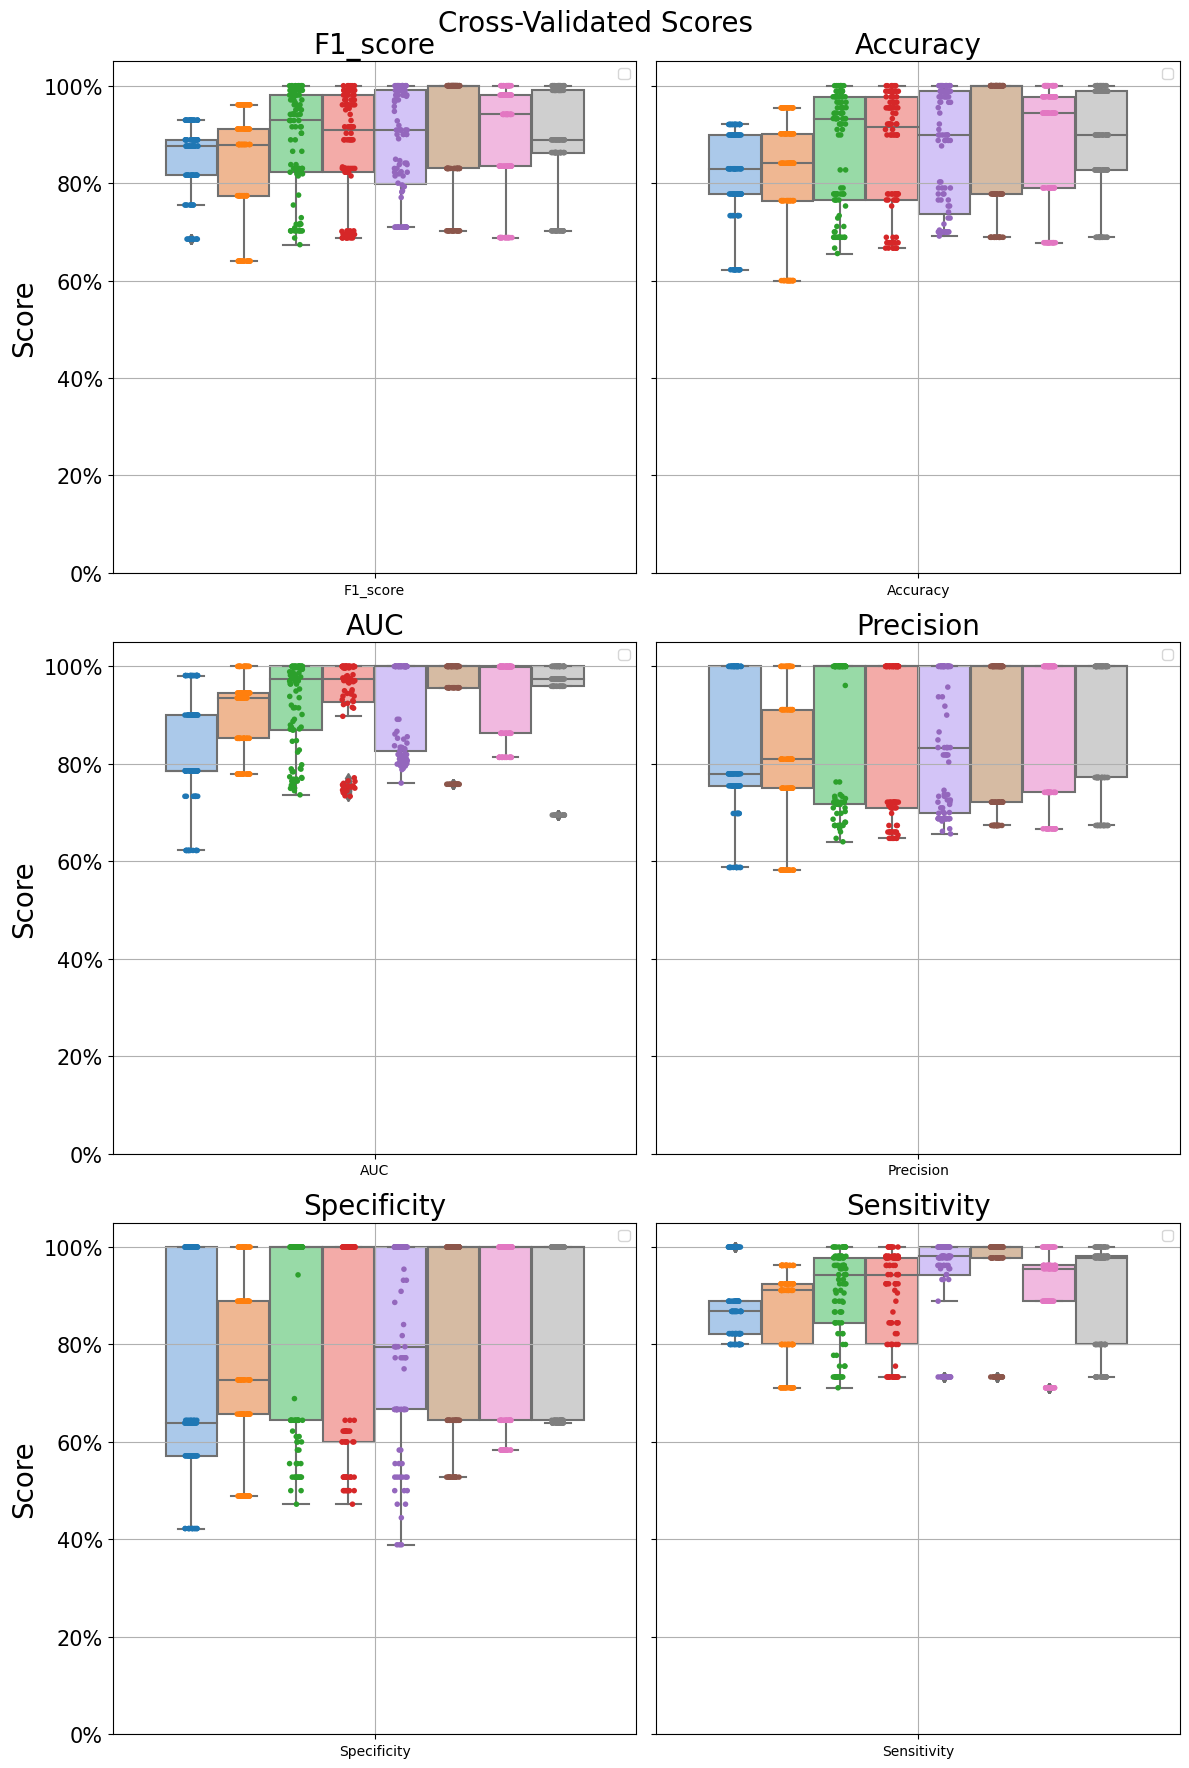

In [44]:
### with swarm plot cv

fig, ax = plt.subplots(3, 2, figsize=(12,18), sharey=True)
met = ['F1_score', 'Accuracy', 'AUC', 'Precision', 'Specificity','Sensitivity']
comp = [melted[melted.Metric == metric] for metric in met]
for i in range(len(comp)):
    df = comp[i]
    df['order'] = df['Model'].map(mod_dict)
    df.sort_values('order')
    
    g = sns.stripplot(x="Metric", y="Score", hue='Model', dodge=True, data=comp[i], zorder=10, ax=ax[i//2, i%2], size = 4)
    g = sns.boxplot(x="Metric", y="Score", hue='Model', palette=sns.color_palette("pastel"), data=comp[i], ax=ax[i//2, i%2])
    if i == 0:
        handles, labels = ax[0,0].get_legend_handles_labels()
        ax[2,1].legend(
            handles,
            labels,
            loc='lower left',
            prop={'size': 20}
        )
    # Add legend only in the last subplot
    ax[i//2, i%2].legend('')
    ax[i//2, 0].set_ylabel('Score', fontsize=20)
    ax[i//2, i%2].set_ylim(0,1.05)
    ax[i//2, 0].set_yticklabels(ax[i//2, 0].get_yticklabels(),fontsize=15)
    ax[i//2, 0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    ax[i//2, i%2].set_xlabel('', fontsize=20)
    ax[i//2, i%2].set_title(met[i], fontsize=20)
    ax[i//2, i%2].grid(True)

plt.suptitle("Cross-Validated Scores", fontsize=20)
plt.tight_layout()
plt.show()


calculate test scores

In [ ]:

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

from sklearn.metrics import confusion_matrix

# Empty lists to store scores
f1t = []
auct = []
acct = []
precisiont = []
recallt = []
specificityt = []
sensitivityt = []
mdl_namest = []

def confusion_matrix_scorer(clf, X, y):
       y_pred = clf.predict(X)
       cm = confusion_matrix(y, y_pred)
       return {'tn': cm[0, 0], 'fp': cm[0, 1],
              'fn': cm[1, 0], 'tp': cm[1, 1]}

for i in range(100):
    for k in range(len(names)):
        mdl = mdls[k]
        rs = np.random.randint(42,414120)
        X_train,X_test,y_train,y_test,g_train,g_test = tts(no_out,intervars,rs=rs)
        mdl.fit(X_train,y_train)
        y_pred = mdl.predict(X_test)

        f1t.append(f1_score(y_test, y_pred))
        auct.append(roc_auc_score(y_test, y_pred))
        acct.append(accuracy_score(y_test, y_pred))
        precisiont.append(precision_score(y_test, y_pred))
        recallt.append(recall_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)

        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        mdl_namest.append(names[k])
    
        sensitivityt.append(tp / (tp + fn))
        specificityt.append(tn / (tn + fp))



# Create DataFrame
testdf = pd.DataFrame({'F1_score': f1t, 'Accuracy': acct, 'AUC': auct, 'Precision': precisiont, 'Recall': recallt, 'Specificity': specificityt, 'Sensitivity': sensitivityt, 'Model': mdl_namest})
meltedt = testdf.melt(id_vars=['Model'], var_name='Metric', value_name='Score')
meltedt.to_csv('fv_test_4.csv')


model statistics

In [25]:
cvscores = pd.read_csv('fv_cv.csv')
print(cvscores.iloc[:,1:].groupby(['Model','Metric']).agg([np.mean,np.std]))


                                 Score          
                                  mean       std
Model            Metric                         
AdaBoost         AUC          0.928458  0.089689
                 Accuracy     0.871491  0.122540
                 F1_score     0.887155  0.111121
                 Precision    0.851925  0.138651
                 Recall       0.933208  0.102269
                 Sensitivity  0.933208  0.102269
                 Specificity  0.800480  0.198936
CatBoost         AUC          0.925596  0.117037
                 Accuracy     0.880712  0.115357
                 F1_score     0.888848  0.108459
                 Precision    0.889080  0.140073
                 Recall       0.898449  0.110461
                 Sensitivity  0.898449  0.110461
                 Specificity  0.856667  0.176440
DT-based Bagging AUC          0.924879  0.090775
                 Accuracy     0.871773  0.118604
                 F1_score     0.885251  0.107342
                 Pre

# ROC curves

/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

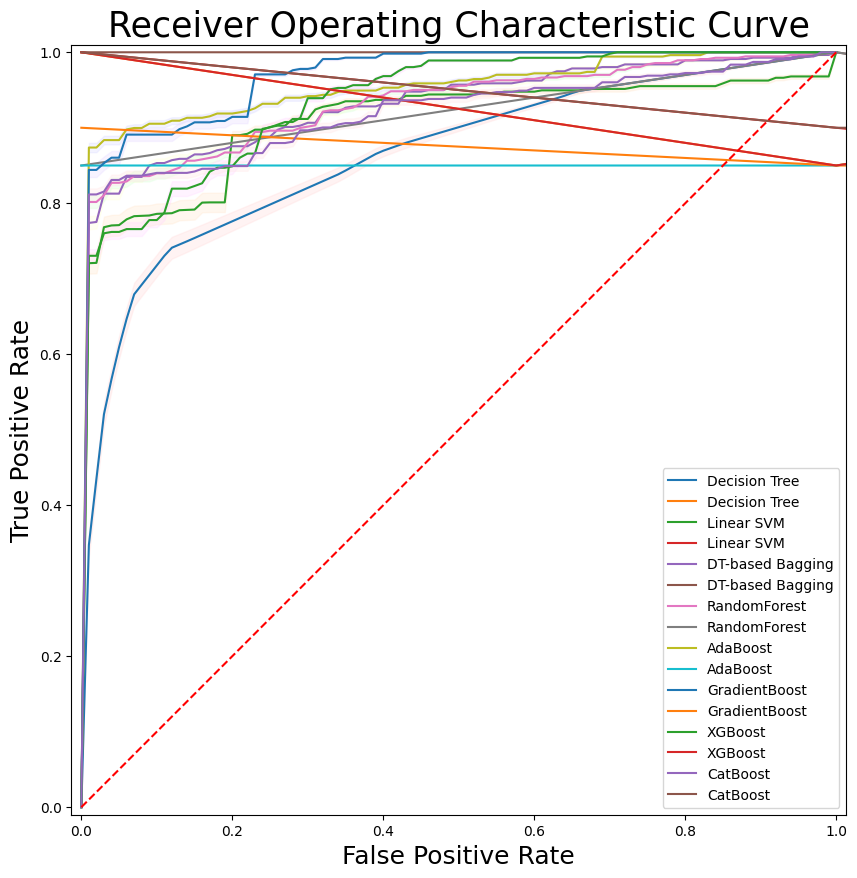

In [29]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,10))
plt.axes().set_aspect('equal', 'datalim')
for m in range(len(mdls)): # your list of models
        tprs = []
        base_fpr = np.linspace(0, 1, 101)
        for i in range(10):
                mdl = mdls[m]
                rs = np.random.randint(42,414120)
                X_train,X_test,y_train,y_test,g_train,g_test = biutils.tts(no_out,intervars,rs=rs) #change data and variable
                mdl.fit(X_train,y_train)
                y_score = mdl.predict_proba(X_test)
                fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
                
                tpr = np.interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                tprs.append(tpr)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)/np.sqrt(len(no_out))
        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std
        plt.plot(base_fpr, mean_tprs, colors[m],label=names[m]) #change names of the models
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = colors[m], alpha=0.3)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend()

plt.title("Receiver Operating Characteristic Curve",fontsize=25)
plt.show()
